In [1]:
!pip install nmrglue
!pip install peakutils
from sys import path_hooks
from scipy.integrate import simps
import pathlib as pth
import numpy as np
import nmrglue as ng
from matplotlib import pyplot as plt
import pandas as pd
from peakutils import baseline
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 3.4 MB/s eta 0:00:00


In [89]:
class SpectraSequence:
    def __init__(self, file_path, sequence):
        self.file_path = file_path
        self.df = pd.read_csv(os.path.join(self.file_path, 'dict.csv'))
        self.sequence = list(sequence)
        self.data = []
        self.dic = []
        self.peak_width = []
        self.center = []
        self.region = []
        self.at = []
        self.phases = []
        self.spectras = []
        self.freqs = []
        self.id_idx = []
        self.areas = []
        self.read_files()
        self.size = [len(self.sequence), len(self.data[0]), [len(self.data[i][0]) for i in range(len(self.data))]]
        self.proper_phases()
        self.noize_spectra_idx()
        self.perform_fourier()

    def read_files(self):
        for i in range(len(self.sequence)):
            tmp = os.path.join(self.file_path, self.sequence[i])
            d, da = ng.varian.read(tmp)
            self.data.append(da)
            self.dic.append(d)
            self.at.append(float(self.dic[i]['procpar']['at']['values'][0]))
            filtered_df = self.df[self.df['nucleus'] == self.sequence[i]]
            if len(filtered_df) == 0:
                raise TypeError("Проверьте файл dict.csv на корректность данных")
            self.peak_width.append(filtered_df['peak_width'].values[0])
            self.center.append(filtered_df['center'].values[0])
            self.region.append(filtered_df['borders'].values[0])

    def proper_phases(self):
        for i in range(self.size[0]):
            spectrum_unpr = np.fft.fft(self.data[i][0])
            spectrum, phase = ng.proc_autophase.autops(spectrum_unpr, 'acme', return_phases=True)
            self.phases.append(phase)

    def noize_spectra_idx(self):
        for i in range(self.size[0]):
            max_vals = []
            for k in range(len(self.data[i])):
                spectrum = np.fft.fft(self.data[i][k]) * np.exp(1j * 2 * np.pi / 360 * (self.phases[i][0]))
                maxima = max(np.real(spectrum))
                max_vals.append(maxima)
            threshold = np.mean(max_vals) / 5
            indices = [i for i, value in enumerate(max_vals) if value < threshold]
            self.id_idx.append(indices)
            if len(self.id_idx[i]) != 9:
                raise ValueError('Убедитесь, что спектр ' + self.sequence[i] + ' достаточно четкий, либо подберите treshhold внутри метода')

    def assymetric_spectra_idx(self):
        return self.ass_idx

    def perform_fourier(self):
        for i in range(self.size[0]):
            freq = np.fft.fftfreq(len(self.data[i][0]), self.at[i] / len(self.data[i][0]))
            mask = (freq >= self.center[i] - self.region[i]) & (freq <= self.center[i] + self.region[i])
            self.freqs.append(freq[mask])
            spec_set = []
            for j in range(len(self.data[i])):
                if j not in self.id_idx:
                    spectrum = np.fft.fft(self.data[i][j]) * np.exp(1j * 2 * np.pi / 360 * (self.phases[i][0]))
                    spec_set.append(spectrum[mask])
            self.spectras.append(spec_set)

    def locate_peaks(self):
        for i in range(self.size[0]):
            loc_peaks = ng.analysis.peakpick.pick(normalized_spectrum, 0.3, -0.3, table=True)

    def plot_spectras(self):
        k = True

    def test(self):
      return self.noize_spectra_idx()




In [90]:
ss = SpectraSequence(r'test', 'HC')

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 132
         Function evaluations: 246
Optimization terminated successfully.
         Current function value: 1062.591951
         Iterations: 96
         Function evaluations: 182


Optimization terminated successfully.
         Current function value: 1062.591951
         Iterations: 96
         Function evaluations: 182


IndexError: index 18 is out of bounds for axis 0 with size 18

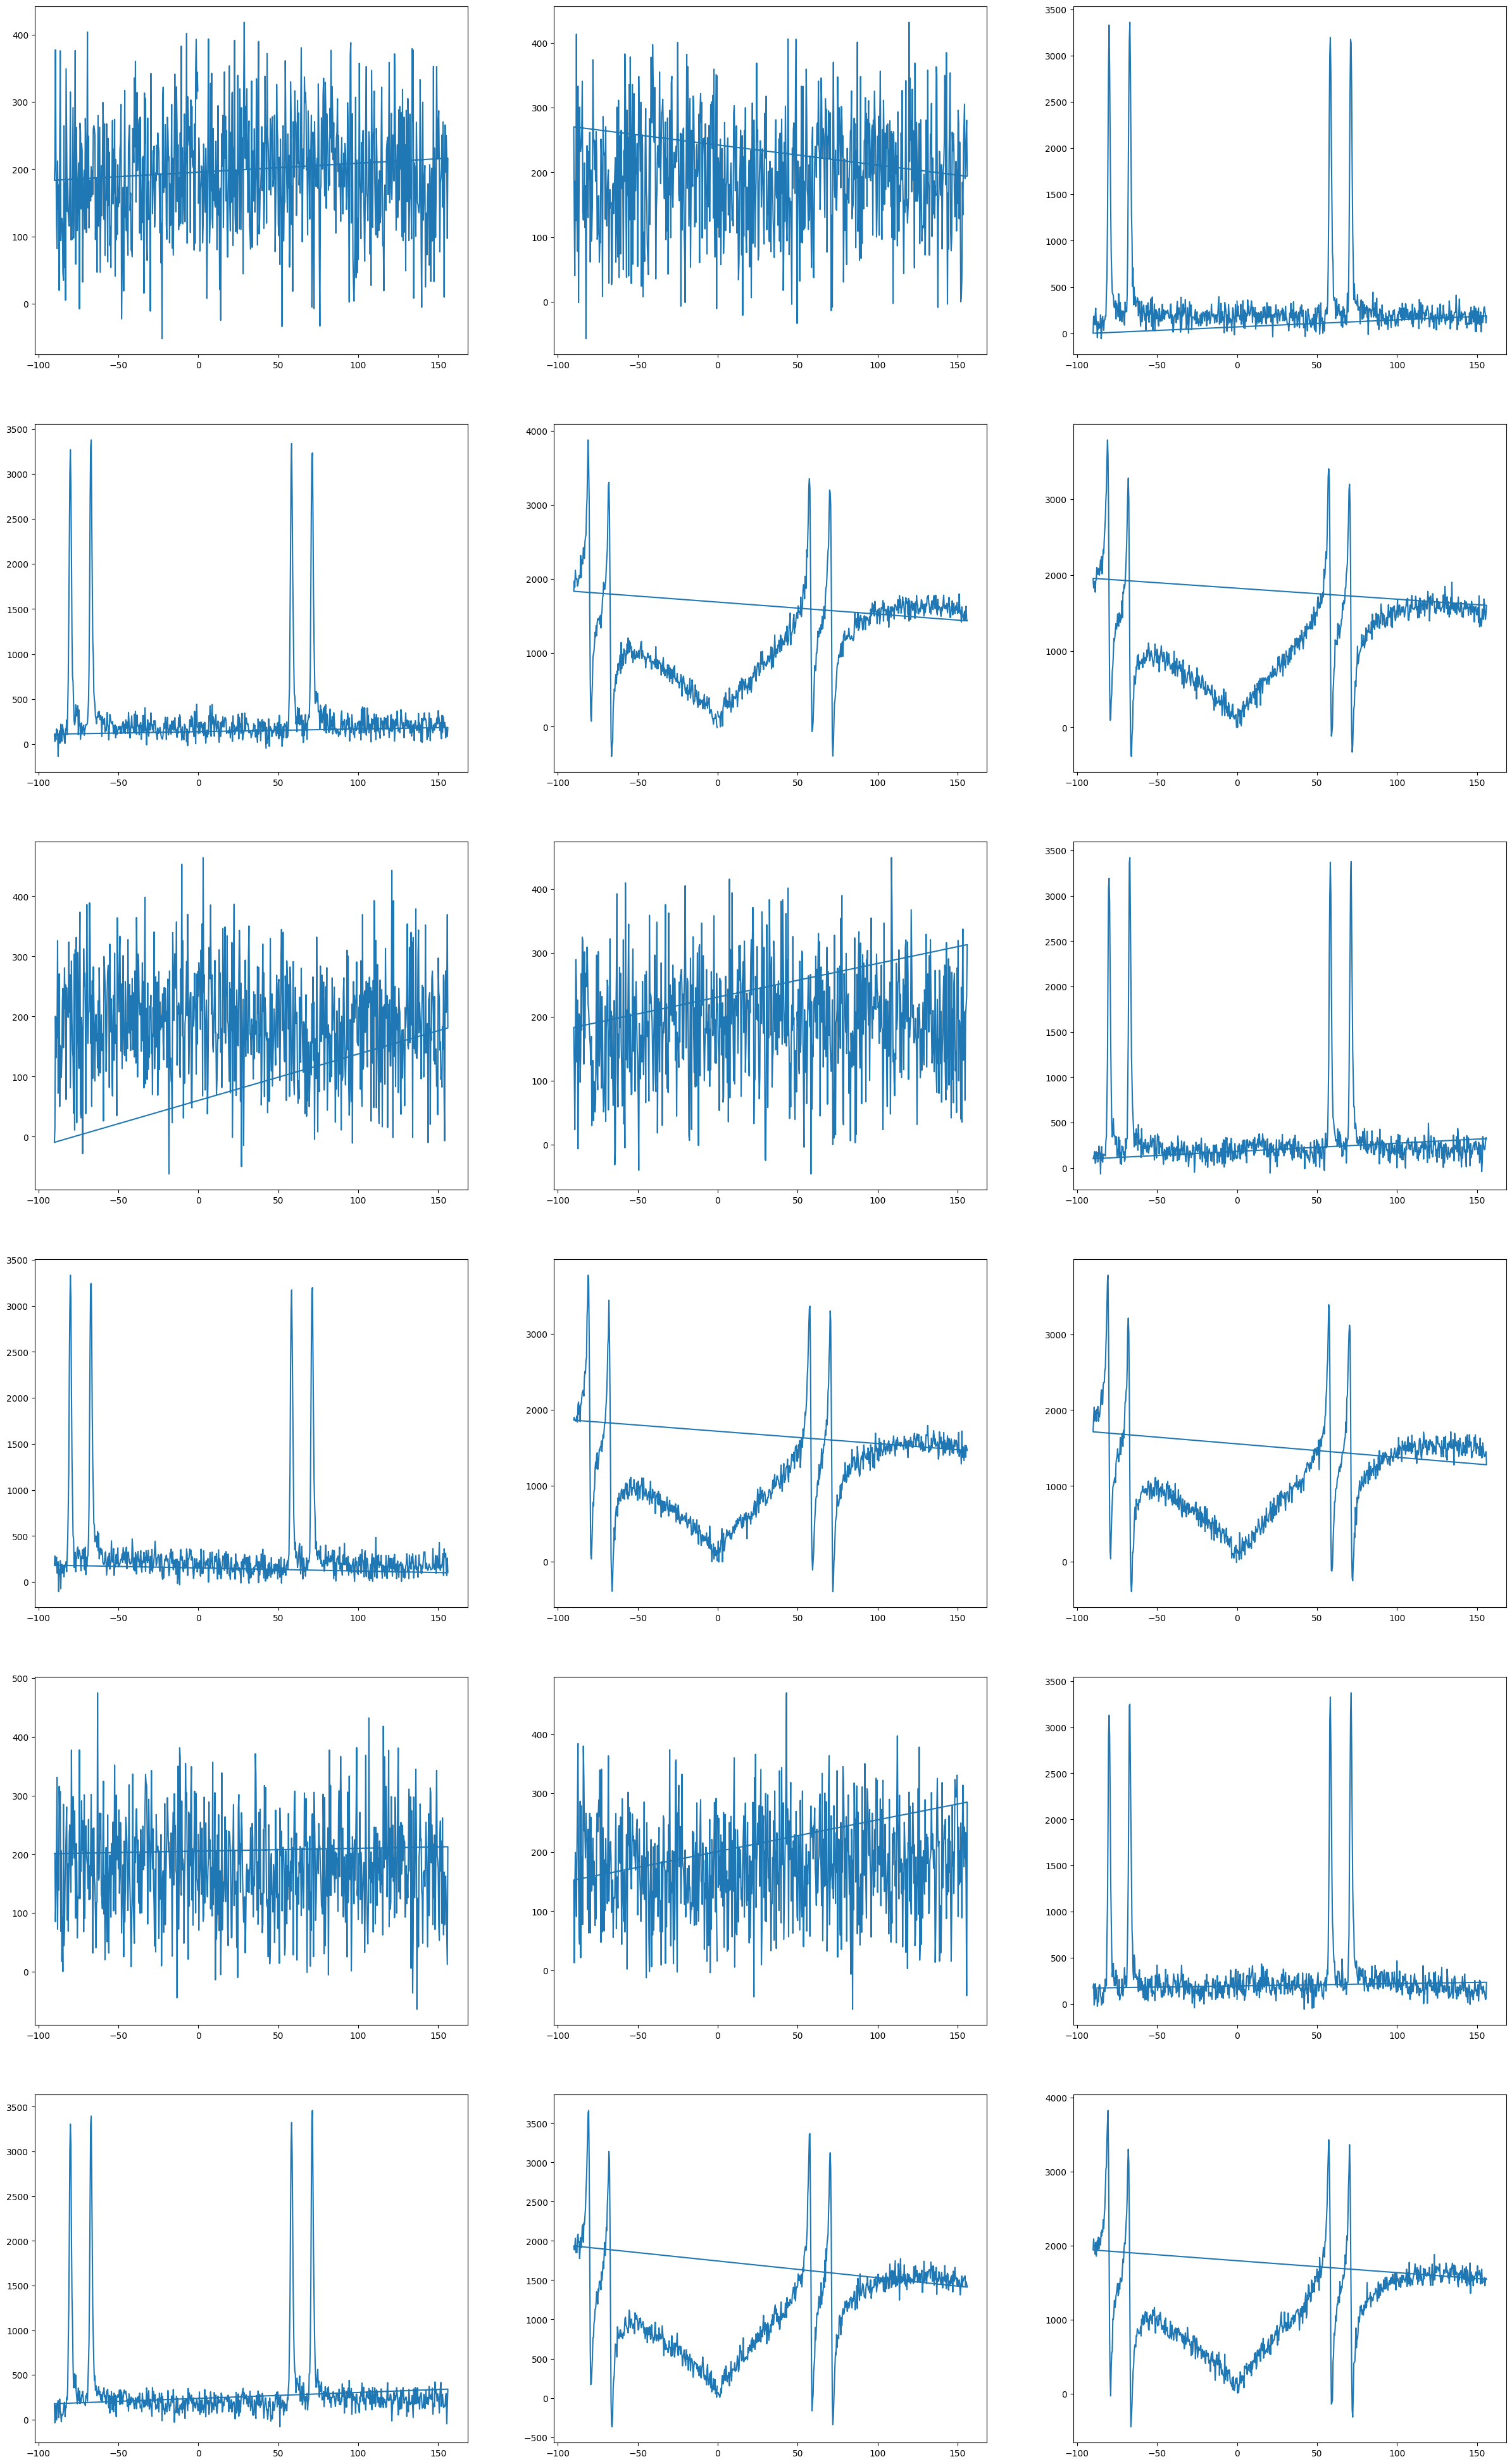

In [94]:
from scipy import signal

def proper_phases(data, window):
    spectrum_unpr = np.fft.fft(window * data[0])
    spectrum, phases = ng.proc_autophase.autops(spectrum_unpr, 'acme', return_phases=True)
    return phases

def noize_spectra_idx(data):
    max_vals = []
    for i in range(len(data)):
        spectrum_unpr = np.fft.fft(data[i])
        maxima = max(np.real(spectrum_unpr))
        max_vals.append(maxima)
    threshold = np.mean(maxima) / 100
    indices = [i for i, value in enumerate(max_vals) if value < threshold]
    return indices



tn = 'C' # Название исследуемого ядра

dic, data = ng.varian.read(r'test//C')
df = pd.read_csv('test//dict.csv')
filtered_df = df[df['nucleus'] == 'C']
at = float(dic['procpar']['at']['values'][0])
peak_width = filtered_df['peak_width'].values[0]
center = filtered_df['center'].values[0]
region = filtered_df['borders'].values[0]

window = 1
phases = proper_phases(data, window)
id_idx = noize_spectra_idx(data)
n = len(data[0])
time = np.linspace(0, at, n)
dt = at / n

frequencies = np.fft.fftfreq(n, d=dt)
dnu = frequencies[1] - frequencies[0]
peak_idx_width = int(peak_width / dnu)
mask = (frequencies >= center-region) & (frequencies <= center+region)
frequencies = frequencies[mask]

integrated_areas = []
fig, axs = plt.subplots(6, 3, figsize=(30, 50))
axs = axs.flatten()
spectras = []
peaks = []

for idx in range(len(data)):
    if idx not in id_idx and idx != 0:
        spectrum = np.fft.fft(window * (data[idx]))[mask]
        ph_corrected_spectrum = np.real(spectrum * np.exp(1j * 2 * np.pi / 360 * (phases[0])))
        normalized_spectrum = ph_corrected_spectrum / max(ph_corrected_spectrum)
        bl = baseline(ph_corrected_spectrum, 3)
        corrected_spectrum = ph_corrected_spectrum - bl
        loc_peaks = ng.analysis.peakpick.pick(normalized_spectrum, 0.3, -0.3, table=True)
        iter = 1
        area_indices = []
        for peak in loc_peaks:
            left = int(peak[0] - peak_idx_width)
            right = int(peak[0] + peak_idx_width)
            # area = simps(np.real(ph_corrected_spectrum[left:right]), frequencies[left:right])
            # integrated_areas.append([{'index':idx + 1}, {'integral_num': iter}, {'area':area}])
            iter += 1
        peaks.append(loc_peaks)
        spectras.append(corrected_spectrum)

for idx in range(len(spectras)):
    axs[idx].plot(frequencies, spectras[idx])
    for i in range(len(peaks[idx])):
        s = int(peaks[idx][i][0] + peak_idx_width)
        p = int(peaks[idx][i][0] - peak_idx_width)
        # axs[idx].axvline(x=frequencies[s], color='orange', linestyle='--')
        # axs[idx].axvline(x=frequencies[p], color='blue', linestyle='--')
plt.show()

NameError: name 'proper_phases' is not defined